Trying to reimplement the original alpha code

--> Using Word embeddings

--> Then PCA

--> Then MLP

Then concat every output vector of each words of a sentence
Finally feed it as params to our model

In [1]:
import os
import warnings
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
import numpy as np
import torch
import json

In [3]:
#Dimension of the reduced word embedding by PCA
REDUCED_WORD_EMBEDDING_DIMENSION = 22

In [4]:
with open('../../../../data/amazonreview_reduced_bert_train.json') as f:
    data = json.load(f)
    dftrain = pd.DataFrame(data)
    dftrain["class"]= dftrain["class"].map({"2": [1,0], "1": [0,1]})

In [5]:
dftrain

,class,sentence,tree,sentence_vectorized
0,"[0, 1]",this one seemed inappropriate,s[n[(n/n) n] (s\\n)[((s\\n)/(s\\n)) (s\\n)]],"[[[-0.23963662981987, 0.12220679968595505, -0...."
1,"[0, 1]",Its Time Has Passed,s[n[(n/n) n] (s\\n)[((s\\n)/(s\\n)) (s\\n)]],"[[[-0.15261103212833405, 0.2917112112045288, 0..."
2,"[0, 1]",This documentary is offensive,s[n[(n/n) n] (s\\n)[((s\\n)/(s\\n)) (s\\n)]],"[[[-0.23963662981987, 0.12220679968595505, -0...."
3,"[1, 0]",this one was ok,s[n[(n/n) n] (s\\n)[((s\\n)/(s\\n)) (s\\n)]],"[[[-0.23963662981987, 0.12220679968595505, -0...."
4,"[1, 0]",The lyrics are incredible,s[n[(n/n) n] (s\\n)[((s\\n)/(s\\n)) (s\\n)]],"[[[-0.20248739421367645, 0.12795767188072205, ..."
...,...,...,...,...
3495,"[0, 1]",3 copies malfunctioned,s[n[n[(n/n) n]] (s\\n)],"[[[-0.482887864112854, 0.28325384855270386, -0..."
3496,"[0, 1]",power button broke,s[n[n[(n/n) n]] (s\\n)],"[[[-0.13493812084197998, 0.1661742925643921, -..."
3497,"[1, 0]",GI JOE ROCKS,s[n[n[(n/n) n]] (s\\n)],"[[[-0.31781184673309326, 0.045452967286109924,..."
3498,"[1, 0]",Storm Trooper Rocks,s[n[n[(n/n) n]] (s\\n)],"[[[-0.24343563616275787, 0.019909895956516266,..."


In [6]:
def custom_list_reshaper(array):
        """ reshapes [[[x]],[[y]],...] into [[x],[y],...]"""
        
        new_array = []
        for sub_array in array:
            new_array.append(sub_array[0])
        return new_array

In [7]:
def apply_pca(df, n_components):
    """ applies pca to the array and returns the reduced array"""
    # Convert each array to NumPy array
    np_array = df['sentence_vectorized'].apply(np.array)

    # Concatenate the NumPy arrays into a single array
    np_array = np.concatenate(np_array)

    pca = PCA(n_components=n_components)
    pca.fit(np_array)

    print('PCA explained variance:', pca.explained_variance_ratio_.sum())

    return df['sentence_vectorized'].apply(lambda x: pca.transform(x))

In [8]:
def preprocess_dataset(file):
    """
    Preprocess function for the dataset + Create train/test split
    """
    with open(file) as f:
        data = json.load(f)
        df_dataset = pd.DataFrame(data)
        df_dataset["class"]= df_dataset["class"].map({"2": 1, "1": 0})

    df_dataset['sentence_vectorized'] = df_dataset['sentence_vectorized'].apply(lambda x: custom_list_reshaper(x))
    df_dataset['sentence_vectorized'] = apply_pca(df_dataset, REDUCED_WORD_EMBEDDING_DIMENSION)

    X_train, X_test, y_train, y_test = train_test_split(df_dataset[['sentence', 'sentence_vectorized']], df_dataset['class'], test_size=0.2)

    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = preprocess_dataset('../../../../data/amazonreview_reduced_bert_train.json')

PCA explained variance: 0.6321208450127307


In [10]:
#For testing purposes
#X_train = X_train[0:400]
#y_train = y_train[0:400]
#X_test = X_test[0:100]
#y_test = y_test[0:100]

In [11]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(X_train['sentence'].values.tolist(), suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(X_test['sentence'].values.tolist(), suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [12]:
from lambeq import Rewriter
# Apply rewrite rule for prepositional phrases

rewriter = Rewriter(['prepositional_phrase', 'determiner', 'curry'])

raw_train_diagrams = [rewriter(diagram) for diagram in raw_train_diagrams]
raw_val_diagrams = [rewriter(diagram) for diagram in raw_val_diagrams]

In [13]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, y_train)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, y_test)
    if diagram is not None
]

In [14]:
train_diagrams.__len__()

2800

In [15]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=4, n_single_qubit_params=3)

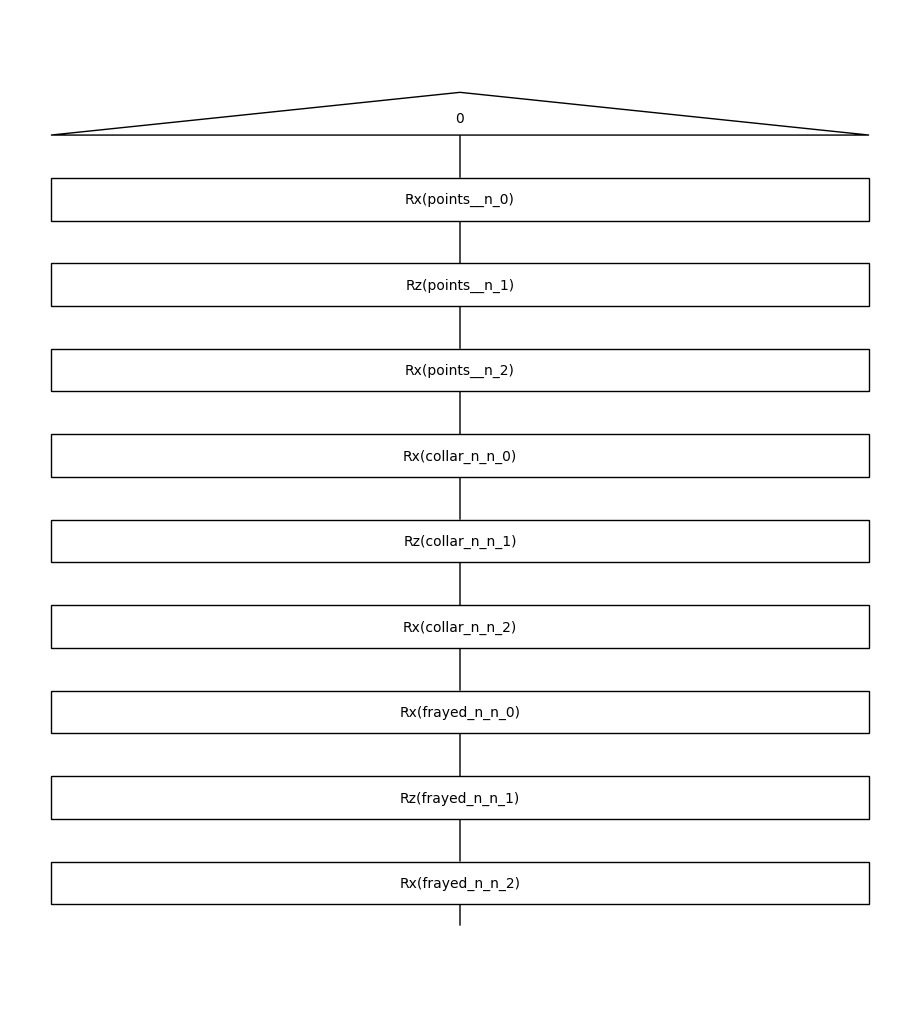

In [17]:
train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

train_circuits[0].draw(figsize=(9, 10))

## Hybrid QNLP Model

In [18]:
BATCH_SIZE = 2048
EPOCHS = 50
SEED = 2
LR = 5e-2
GAMMA_LR = 0.5    # Learning rate reduction applied every STEP_LR epochs.
STEP_LR = 20

In [19]:
from torch import nn
from lambeq import PennyLaneModel

# inherit from PennyLaneModel to use the PennyLane circuit evaluation
class DressedQuantumModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

        self.pre_qc = nn.Sequential(nn.Linear(REDUCED_WORD_EMBEDDING_DIMENSION, len(self.weights)),
                                    nn.LeakyReLU(0.01))

        #self.post_qc = nn.Sequential(nn.Linear(2, 10),
        #                             nn.LeakyReLU(0.01),
        #                             nn.Linear(10, 1),
        #                             nn.Sigmoid())
        
        self.post_qc = nn.Sequential(nn.Linear(2, 1),
                                nn.Sigmoid())


    def forward(self, diagram, embeddings):
        sentence_q_params = []
        for embedding in embeddings:
            sentence_q_params.append(self.forward_word(embedding))


        #qparams = torch.cat(sentence_q_params)

        self.weights = torch.nn.ParameterList(
            [torch.nn.Parameter(emb)
             for emb in sentence_q_params]
        )

        diagram = self.get_diagram_output(diagram)
        
        # pass the concatenated results through a simple neural network
        return self.post_qc(diagram)
    
    def forward_word(self, embedding):
        # pass the embedding through a simple neural network
        embedding_out = self.pre_qc(embedding)
        
        return embedding_out
    

In [20]:
all_circuits = train_circuits + val_circuits

In [21]:
from lambeq import Dataset

# initialise datasets and optimizers as in PyTorch
train_dataset = Dataset(list(zip(train_circuits, np.vstack(X_train['sentence_vectorized'].apply(np.array)))),
                        train_labels,
                        batch_size=BATCH_SIZE)

valid_dataset = Dataset(list(zip(val_circuits, np.vstack(X_test['sentence_vectorized'].apply(np.array)))),
                        val_labels,
                        batch_size=BATCH_SIZE)


In [22]:
model = DressedQuantumModel.from_diagrams(all_circuits, probabilities=True, normalize=True)
# initialise our model by passing in the diagrams, so that we have trainable parameters for each token
model.initialise_weights()
model = model.double()

In [23]:
def accuracy(circuits, embeddings, labels):
    predicted = model(circuits, torch.from_numpy(np.vstack(embeddings)))
    return (torch.round(torch.flatten(predicted)) ==
            torch.DoubleTensor(labels)).sum().item()/len(circuits)

In [24]:
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-2)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, step_size=STEP_LR, gamma=GAMMA_LR
)

In [25]:
from torch.utils.tensorboard import SummaryWriter
import datetime

log_dir = "logs/fit_pennylane_lambeq_original/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = SummaryWriter(log_dir=log_dir)

In [26]:
best = {'acc': 0, 'epoch': 0}
best_val_loss = 1000
best_val_acc = 0
best_train_loss = 1000
best_acc_train = 0

for epoch in range(EPOCHS):
    print('Epoch: {}'.format(epoch))
    running_loss = 0.0
    running_corrects = 0

    #for circuits, embeddings, labels in train_dataloader:
    for input, labels in train_dataset:
        batch_size_ = len(input)
        circuits, embeddings = np.array(input).T
        optimizer.zero_grad()
        predicted = model(circuits, torch.from_numpy(np.vstack(embeddings)))

        # use BCELoss as our outputs are probabilities, and labels are binary
        loss = criterion(torch.flatten(predicted), torch.DoubleTensor(labels))
        #running_loss += loss.item()
        running_loss += loss.item()*batch_size_
        loss.backward()
        optimizer.step()

        batch_corrects = (torch.round(torch.flatten(predicted)) == torch.DoubleTensor(labels)).sum().item()
        running_corrects += batch_corrects
        


    # Print epoch results
    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects / len(train_dataset)
    

    summary_writer.add_scalar("Training/Loss", train_loss, epoch)
    summary_writer.add_scalar("Training/Acurracy", train_acc, epoch)

    if train_loss < best_train_loss:
        best_train_loss = train_loss

    if train_acc > best_acc_train:
        best_acc_train = train_acc

    running_loss = 0.0
    running_corrects = 0

    # evaluate on valid set every 5 epochs
    # save the model if it's the best so far
    # stop training if the model hasn't improved for 10 epochs
    for input, labels in valid_dataset:
        batch_size_ = len(input)
        circuits, embeddings = np.array(input).T
        optimizer.zero_grad()
        predicted = model(circuits, torch.from_numpy(np.vstack(embeddings)))

        loss = criterion(torch.flatten(predicted), torch.DoubleTensor(labels))
        running_loss += loss.item()*batch_size_


        batch_corrects = (torch.round(torch.flatten(predicted)) == torch.DoubleTensor(labels)).sum().item()
        running_corrects += batch_corrects


    validation_loss = running_loss / len(valid_dataset)
    validation_acc = running_corrects / len(valid_dataset)

    summary_writer.add_scalar("Validation/Loss", validation_loss, epoch)
    summary_writer.add_scalar("Validation/Acurracy", validation_acc, epoch)

    exp_lr_scheduler.step()
    
    print('Train loss: {}'.format(train_loss))
    print('Valid loss: {}'.format(train_acc))
    print('Train acc: {}'.format(validation_loss))
    print('Valid acc: {}'.format(validation_acc))

    if validation_acc > best_val_acc:
            best_val_acc = validation_acc
            best['epoch'] = epoch
            model.save('nlp_dressed_alpha_model.lt')
    #elif epoch - best['epoch'] >= 10:
    #    print('Early stopping')
    #    break


    if validation_loss < best_val_loss:
        best_val_loss = validation_loss




# load the best performing iteration of the model on the dev set
#if best['acc'] > accuracy(train_circuits, train_labels):
#    model.load('xor_model.lt')
#    model = model.double()

Epoch: 0
Train loss: 0.7158591214189094
Valid loss: 0.48678571428571427
Train acc: 0.6935872145541419
Valid acc: 0.5214285714285715
Epoch: 1
Train loss: 0.6960797581658205
Valid loss: 0.5142857142857142
Train acc: 0.7029713677513302
Valid acc: 0.4928571428571429
Epoch: 2
Train loss: 0.693681405038065
Valid loss: 0.5192857142857142
Train acc: 0.697571666527592
Valid acc: 0.49857142857142855
Epoch: 3
Train loss: 0.6932721371939795
Valid loss: 0.5239285714285714
Train acc: 0.6901027692738171
Valid acc: 0.5357142857142857
Epoch: 4
Train loss: 0.6923695025314421
Valid loss: 0.5325
Train acc: 0.6877402955569356
Valid acc: 0.5485714285714286
Epoch: 5
Train loss: 0.6898252248663275
Valid loss: 0.5378571428571428
Train acc: 0.6902515172402806
Valid acc: 0.5314285714285715
Epoch: 6
Train loss: 0.6910675483408479
Valid loss: 0.5310714285714285
Train acc: 0.6913166847980742
Valid acc: 0.5285714285714286
Epoch: 7
Train loss: 0.6912912315366805
Valid loss: 0.5360714285714285
Train acc: 0.69366064505

In [ ]:
summary_writer.add_hparams({'lr': LR, 'gamma_lr': GAMMA_LR, 'step_lr': STEP_LR},
                      {'hparam/loss_train': best_train_loss, 'hparam/acc_train': best_acc_train,
                       'hparam/loss_valid': best_val_loss, 'hparam/acc_valid': best_val_acc})